<a href="https://colab.research.google.com/github/peppermintpiglet/BIO594/blob/main/project3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up The Environment
First we will upload the necessary libiraries, a tool for uploading datasets from Zenodo, and all the tensorflow libraries and tools in order to set up the CNN.

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import sklearn
import glob

!pip install zenodo_get
import zenodo_get

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import KFold

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=6a74e15b7b8e0623494a9c156a6bd07a94138d631bc752109b80a1c6159c1833
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


We'll also verify the version of tensorflow and keras that's being used.

In [ ]:
print(f"Tensorflow version : {tf.__version__}")
print(f"Keras version : {keras.__version__}")

Tensorflow version : 2.17.1
Keras version : 3.5.0


Then we will make our directory file in the main folder.
I am not mounting my google drive anymore because it causes the data to transfer to the drive and take up space, resulting in overload.


In [ ]:
# prompt: make directory within content named PROJECT3DATA

import os

# Create the directory if it doesn't exist
directory = "/content/PROJECT3DATA"
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Collecting the Data
We will also upload our dataset files from Zenodo by using a tool designed to pull datasets based on their DOI or Record ID (there was not enough room to store them on our Google drive).

---
The dataset that we will be using is histology images from CRC patients oringinating from The Cancer Genome Atlas. These samples have already underwent preprocessing and have been split into training and testing sets.  

*Kather, J. N. (2019). Histological images for MSI vs. MSS classification in gastrointestinal cancer, FFPE samples [Data set]. Zenodo. https://doi.org/10.5281/zenodo.2530835*


---

We only want the images associated with CRC, not gastric cancer, so we'll be limiting the files which are uploaded. This is done using a "glob" expression to select files which start with "CRC_DX_TEST" or "CRC_DX_TRAIN". This could be performed by filtering for "CRC_DX", but since I am separating the training and testing data into separate folders I chose to do the filtering individually.

In [ ]:
!zenodo_get 10.5281/zenodo.2530835 --glob='CRC_DX_TEST*.zip' --output-dir='/content/PROJECT3DATA/CRCTEST'

Title: Histological images for MSI vs. MSS classification in gastrointestinal cancer, FFPE samples
Keywords: 
Publication date: 2019-02-07
DOI: 10.5281/zenodo.2530835
Total size: 11.1 GB

Link: https://zenodo.org/records/2530835/files/CRC_DX_TEST_MSS.zip   size: 7.9 GB

Checksum is correct. (3407a53dddec68e67f49b863a3520e88)

Link: https://zenodo.org/records/2530835/files/CRC_DX_TEST_MSIMUT.zip   size: 3.3 GB

Checksum is correct. (006962fd57ffa71db43f3d768a63d9ec)
All files have been downloaded.


In [ ]:
!zenodo_get 10.5281/zenodo.2530835 --glob='CRC_DX_TRAIN*.zip' --output-dir='/content/PROJECT3DATA/CRCTRAIN'

Title: Histological images for MSI vs. MSS classification in gastrointestinal cancer, FFPE samples
Keywords: 
Publication date: 2019-02-07
DOI: 10.5281/zenodo.2530835
Total size: 10.5 GB

Link: https://zenodo.org/records/2530835/files/CRC_DX_TRAIN_MSIMUT.zip   size: 5.3 GB

Checksum is correct. (d98f4ee32f5923a09779d9aabd773e37)

Link: https://zenodo.org/records/2530835/files/CRC_DX_TRAIN_MSS.zip   size: 5.3 GB

Checksum is correct. (0dbb048590925920c383e423fa282f77)
All files have been downloaded.


Next we want to unzip these files so we can access the images that they contain. This is best performed using the unzip function. We will be using `-q` so that it does not report on the extraction of every image from the files. The `-d` designates the destination for the extracted files, which will each be contained within a folder corresponding with the mutational status of the images enclosed.

In [ ]:
!unzip -q /content/PROJECT3DATA/CRCTEST/CRC_DX_TEST_MSIMUT.zip -d /content/PROJECT3DATA/CRCTEST

In [ ]:
!unzip -q /content/PROJECT3DATA/CRCTEST/CRC_DX_TEST_MSS.zip -d /content/PROJECT3DATA/CRCTEST

In [ ]:
!unzip -q /content/PROJECT3DATA/CRCTRAIN/CRC_DX_TRAIN_MSIMUT.zip -d /content/PROJECT3DATA/CRCTRAIN

In [ ]:
!unzip -q /content/PROJECT3DATA/CRCTRAIN/CRC_DX_TRAIN_MSS.zip -d /content/PROJECT3DATA/CRCTRAIN

Let's visualize our images to make sure everything is as expected.

# Data Processing
We need to determine the number of files in each path for the training and testing sets.
This should be 93,408 total images for the CRCTRAIN folder and 99,904 total images for the CRCTEST


In [ ]:


batchtest = len(os.listdir('/content/PROJECT3DATA/CRCTEST/MSIMUT')) + len(os.listdir('/content/PROJECT3DATA/CRCTEST/MSS'))
batchtrain = len(os.listdir('/content/PROJECT3DATA/CRCTRAIN/MSIMUT')) + len(os.listdir('/content/PROJECT3DATA/CRCTRAIN/MSS'))

print(batchtest)
print(batchtrain)




98904
93408


We can't run analysis on this many images within the Google Colab environment, so we need to reduce the amount of data we're processing. This can be done by taking a random sample of the overall dataset while conserving the proportion of MSS and MSI cases being represented. Additionally, we can adjust these values to make them more representative of a traditional 70/30 split.

---


Credit to https://stackoverflow.com/questions/49280966/pulling-random-files-out-of-a-folder-for-sampling for the solution on how to select a random sample of files from a directory.

In [ ]:
#Selecting a random sample of the files to make the analysis possible within the limitation of Google Colab

##For the testing data
# list all files in dir
mss_test_files  = os.listdir('/content/PROJECT3DATA/CRCTEST/MSS')
msimut_test_files  = os.listdir('/content/PROJECT3DATA/CRCTEST/MSIMUT')

# Select approximately ~290 of the files randomly for each class of the test set
random_mss_test_files = np.random.choice(mss_test_files, int(len(mss_test_files)*0.004))
random_msimut_test_files = np.random.choice(msimut_test_files, int(len(msimut_test_files)*0.01))

#merging the test files
#random_test_files = np.concatenate((random_mss_test_files, random_msimut_test_files))

##For the training data
# list all files in dir
mss_train_files  = os.listdir('/content/PROJECT3DATA/CRCTRAIN/MSS')
msimut_train_files  = os.listdir('/content/PROJECT3DATA/CRCTRAIN/MSIMUT')

# Select 0.008 of the files randomly resulting in about 750 files for each
random_mss_train_files = np.random.choice(mss_train_files, int(len(mss_train_files)*0.016))
random_msimut_train_files = np.random.choice(msimut_train_files, int(len(msimut_train_files)*0.016))

#merging the test files
#random_train_files = np.concatenate((random_mss_test_files, random_msimut_test_files))



We can now store the random samples within a new folder structure so they are easy to select later on.

In [ ]:
# prompt: Make a folder named SAMPLE in the PROJECT3DATA folder

# Create the SAMPLE directory inside PROJECT3DATA
directory = "/content/PROJECT3DATA/TESTSAMPLE"
if not os.path.exists(directory):
    os.makedirs(directory)

# Create the SAMPLE directory inside PROJECT3DATA
directory = "/content/PROJECT3DATA/TRAINSAMPLE"
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
# prompt: put files into a directory

import shutil

# Create subdirectories within PROJECT3DATA if they don't exist
subdirectories = ["TESTSAMPLE/MSS", "TESTSAMPLE/MSIMUT", "TRAINSAMPLE/MSS", "TRAINSAMPLE/MSIMUT"]
for subdir in subdirectories:
    path = os.path.join("/content/PROJECT3DATA", subdir)
    if not os.path.exists(path):
        os.makedirs(path)

# Move the randomly selected files to their respective subdirectories
# ... (Your existing code for selecting random files: random_mss_test_files, etc.)

source_test_mss = "/content/PROJECT3DATA/CRCTEST/MSS"
source_test_msimut = "/content/PROJECT3DATA/CRCTEST/MSIMUT"
dest_test_mss = "/content/PROJECT3DATA/TESTSAMPLE/MSS"
dest_test_msimut = "/content/PROJECT3DATA/TESTSAMPLE/MSIMUT"

source_train_mss = "/content/PROJECT3DATA/CRCTRAIN/MSS"
source_train_msimut = "/content/PROJECT3DATA/CRCTRAIN/MSIMUT"
dest_train_mss = "/content/PROJECT3DATA/TRAINSAMPLE/MSS"
dest_train_msimut = "/content/PROJECT3DATA/TRAINSAMPLE/MSIMUT"


for file_name in random_mss_test_files:
    source_path = os.path.join(source_test_mss, file_name)
    destination_path = os.path.join(dest_test_mss, file_name)
    if os.path.exists(source_path):
      shutil.move(source_path, destination_path)

for file_name in random_msimut_test_files:
    source_path = os.path.join(source_test_msimut, file_name)
    destination_path = os.path.join(dest_test_msimut, file_name)
    if os.path.exists(source_path):
      shutil.move(source_path, destination_path)


for file_name in random_mss_train_files:
    source_path = os.path.join(source_train_mss, file_name)
    destination_path = os.path.join(dest_train_mss, file_name)
    if os.path.exists(source_path):
      shutil.move(source_path, destination_path)


for file_name in random_msimut_train_files:
    source_path = os.path.join(source_train_msimut, file_name)
    destination_path = os.path.join(dest_train_msimut, file_name)
    if os.path.exists(source_path):
      shutil.move(source_path, destination_path)

Let's check the counts on the datasets after having performed the random sampling and verify the split of the data.

In [ ]:
batchtest = len(os.listdir('/content/PROJECT3DATA/TESTSAMPLE/MSS')) + len(os.listdir('/content/PROJECT3DATA/TESTSAMPLE/MSIMUT'))
batchtrain = len(os.listdir('/content/PROJECT3DATA/TRAINSAMPLE/MSS')) + len(os.listdir('/content/PROJECT3DATA/TRAINSAMPLE/MSIMUT'))

print(batchtest)
print(batchtrain)


562
1484


In [ ]:
test_percent = (batchtest/(batchtest+batchtrain))*100
train_percent = (batchtrain/(batchtest+batchtrain))*100

print(f"{test_percent}% of the data is in the testing set")
print(f"{train_percent}% of the data is in the training set")

27.468230694037143% of the data is in the testing set
72.53176930596285% of the data is in the training set


# Model Set-Up and Training

We can now save the images as a TensorFlow dataset, which allows them to more easily incorporate into the TF workflow. This apporach is taken from [this page](https://www.tensorflow.org/tutorials/images/classification#load_data_using_a_keras_utility) provided by TensorFlow on their website.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/PROJECT3DATA/TRAINSAMPLE',
    labels='inferred',
    label_mode='categorical',
    class_names=['MSIMUT','MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/PROJECT3DATA/TESTSAMPLE',
    labels='inferred',
    label_mode='categorical',
    class_names=['MSIMUT','MSS'],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True
)

Found 1484 files belonging to 2 classes.
Found 562 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['MSIMUT', 'MSS']


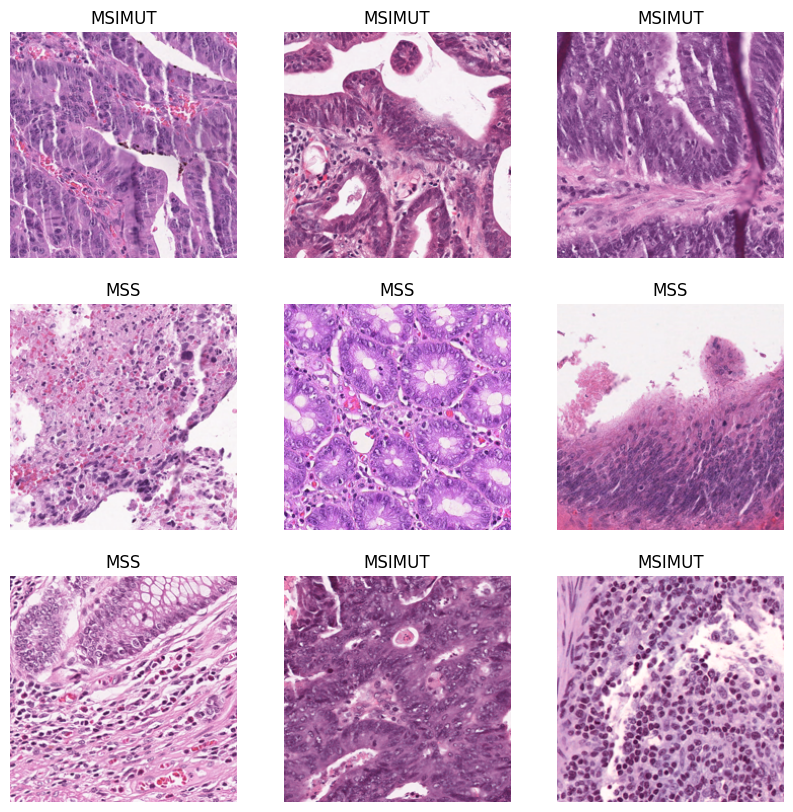

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


In [ ]:
# Model configuration
batch_size = 32
img_width, img_height, img_num_channels = 224, 224, 3
loss_function = binary_crossentropy
no_classes = 2
no_epochs = 20
optimizer = Adam()
verbosity = 1
num_folds = 10

# set image shape for the data
inputShape = (img_width, img_height, img_num_channels)
num_classes = len(class_names)

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

#inputs = np.concatenate((train_ds.images, test_ds.images), axis=0)
#targets = np.concatenate((train_ds.labels, test_ds.labels), axis=0)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

#Define the model
model2 = Sequential([
layers.Rescaling(1./255, input_shape=inputShape),
layers.Conv2D(32, kernel_size=(7,7), padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
layers.MaxPooling2D(),
layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
              layers.BatchNormalization(axis=-1),
              layers.Dropout(0.25),
layers.MaxPooling2D(),
layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
              layers.BatchNormalization(axis=-1),
              layers.Dropout(0.25),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(512, activation='relu', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
              layers.BatchNormalization(),
              layers.Dropout(0.5),
layers.Dense(num_classes, activation="softmax")
])

  # Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

We now set up the CNN based on the provided

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,943,298 (49.37 MB)

 Trainable params: 12,942,914 (49.37 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 331s 7s/step - accuracy: 0.4764 - loss: 1.0076 - val_accuracy: 0.5036 - val_loss: 3.6493
Epoch 2/10
 3/47 ━━━━━━━━━━━━━━━━━━━━ 4:46 7s/step - accuracy: 0.4792 - loss: 0.8475

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_ds, verbose=2)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()